In [4]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [6]:
# 3
# Create separate ImageDataGenerators for each dataset (training, validation, test).
# These generators will read, decode, and convert images into floating point tensors.

# ImageDataGenerator for training set
train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Rescaling the image pixel values to the range [0,1]
)

# ImageDataGenerator for validation set
validation_image_generator = ImageDataGenerator(
    rescale=1./255,  # Rescaling the image pixel values to the range [0,1]
)

# ImageDataGenerator for test set
test_image_generator = ImageDataGenerator(
    rescale=1./255,
)

# Arguments for data generators specifying image properties and batch sizes
data_gen_arg = dict(
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images to a specific height and width
    batch_size=batch_size,
    class_mode='binary',
)

# Generate batches of preprocessed data for training by reading images from the training directory
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,  # Path to the training directory
    subset='training',
    **data_gen_arg

# Generate batches of preprocessed data for validation by reading images from the validation directory
val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,  # Path to the validation directory
    **data_gen_arg  # Pass the data generator arguments
)

# Generate batches of preprocessed data for testing by reading images from the test directory
test_data_gen = test_image_generator.flow_from_directory(
    PATH,  # Main directory containing the test images
    classes=['test'],
    shuffle=False,
    **data_gen_arg
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


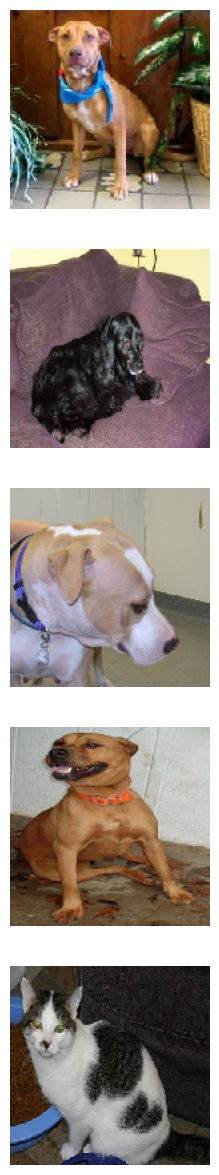

In [7]:
# 4
# Define a function to plot images
def plotImages(images_arr, probabilities=False):
    # Create a plot with multiple subplots based on the number of images provided
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))

    # Check if probabilities are available
    if probabilities is False:
        # Loop through the images and corresponding axes to display them without probabilities
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        # Loop through the images, probabilities, and corresponding axes to display with probabilities
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')

            # Set title based on the predicted probability
            if probability > 0.5:
                ax.set_title("%.2f" % (probability * 100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1 - probability) * 100) + "% cat")

    plt.show()

# Get a batch of sample training images and their corresponding labels
sample_training_images, _ = next(train_data_gen)

# Plot the first five random training images without predicted probabilities
plotImages(sample_training_images[:5])


In [8]:
# 5
# Recreating the train_image_generator using ImageDataGenerator to augment the existing training data.
# Image augmentation helps mitigate overfitting by creating variations from existing examples.

train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Rescaling pixel values to [0,1] as before.

    # Various augmentation techniques to create diverse training examples:
    rotation_range=25,
    shear_range=0.15,
    zoom_range=0.20,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',

    validation_split=0.2,
)



Found 2000 images belonging to 2 classes.


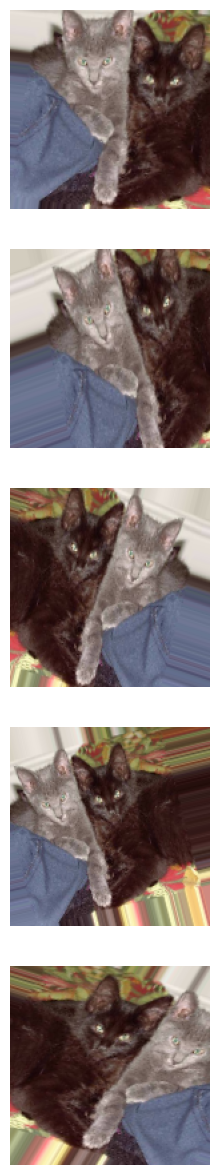

In [9]:
# 6
# Generating an iterator from the augmented training data
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Creating a list of five different variations of a single image from the augmented training data
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

# Plotting the five different variations of the single image
plotImages(augmented_images)


In [10]:
# 7
# Creating a sequential model
model = Sequential()

# Adding a 2D convolutional layer with 32 filters and a 3x3 kernel, using ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

# Adding a max pooling layer to downsample the output of the convolutional layer
model.add(MaxPooling2D((2, 2)))

# Adding another 2D convolutional layer with 64 filters and a 3x3 kernel, using ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Adding another max pooling layer for downsampling
model.add(MaxPooling2D((2, 2)))

# Flattening the output to a 1D array for input into the dense layers
model.add(Flatten())

# Adding a dense layer with 64 neurons and ReLU activation
model.add(Dense(64, activation='relu'))

# Adding the output layer with 4 neurons and sigmoid activation for multi-class classification
model.add(Dense(4, activation='sigmoid'))

# Compiling the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Using sparse categorical crossentropy loss
    optimizer='adam',  # Optimizer algorithm (Adam)
    metrics=['accuracy']  # Metric to monitor during training (accuracy)
)

# Displaying a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [11]:
# 8
#training the network.
history = model.fit(
    train_data_gen,
    epochs = epochs,
    steps_per_epoch = total_train // batch_size,
    validation_data = val_data_gen,
    validation_steps = total_val // batch_size
    )



Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15/15 [==============================] - 93s 6s/step - loss: 2.0400 - accuracy: 0.4920 - val_loss: 0.8121 - val_accuracy: 0.5067
Epoch 2/15
15/15 [==============================] - 80s 5s/step - loss: 0.7440 - accuracy: 0.5198 - val_loss: 0.6873 - val_accuracy: 0.5134
Epoch 3/15
15/15 [==============================] - 78s 5s/step - loss: 0.7076 - accuracy: 0.5150 - val_loss: 0.6898 - val_accuracy: 0.5145
Epoch 4/15
15/15 [==============================] - 78s 5s/step - loss: 0.6816 - accuracy: 0.5721 - val_loss: 0.6558 - val_accuracy: 0.6451
Epoch 5/15
15/15 [==============================] - 79s 5s/step - loss: 0.6560 - accuracy: 0.6074 - val_loss: 0.6240 - val_accuracy: 0.6507
Epoch 6/15
15/15 [==============================] - 79s 5s/step - loss: 0.6410 - accuracy: 0.6298 - val_loss: 0.6139 - val_accuracy: 0.6551
Epoch 7/15
15/15 [==============================] - 78s 5s/step - loss: 0.6332 - accuracy: 0.6538 - val_loss: 0.6900 - val_accuracy: 0.5781
Epoch 8/15
15/15 [=============

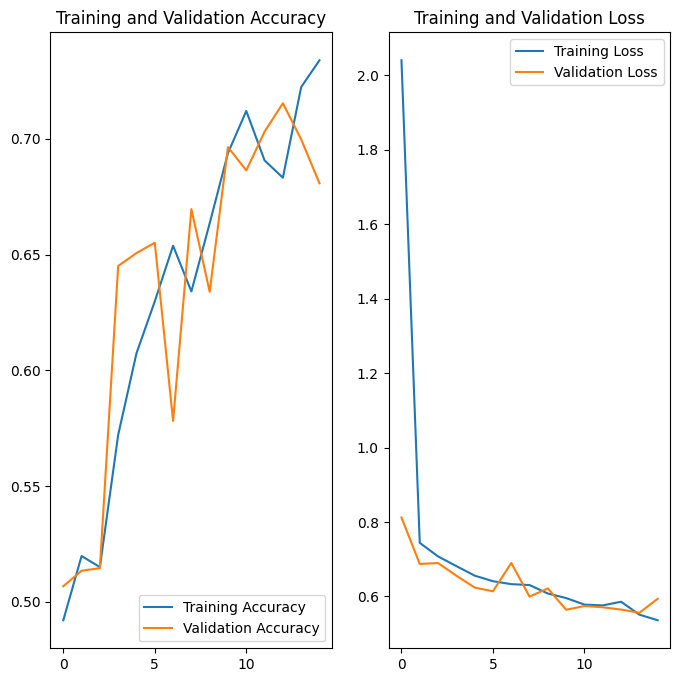

In [12]:
# 9
#visualizing the accuracy and loss of the model.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)


1/1 [==============================] - 1s 1s/step


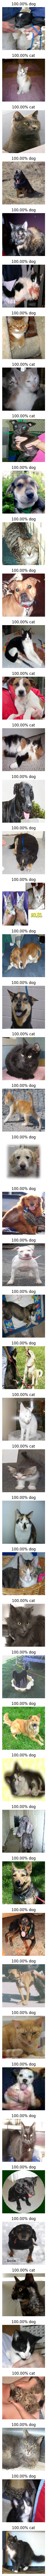

In [14]:
plotImages(test_data_gen[0][0], probabilities)

In [16]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
